In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
'''
Copyright (c) 2018 Norio Tamada
Released under the MIT license
https://github.com/darecophoenixx/wordroid.sblo.jp/blob/master/lib/keras_ex/gkernel/LICENSE.md
'''

import numpy as np
from keras import initializers, constraints
from keras.engine.topology import Layer
from keras import backend as K

class GaussianKernel(Layer):
    
    def __init__(self, num_landmark, num_feature,
                 kernel_initializer='glorot_uniform',
                 kernel_constraint=None,
                 kernel_gamma='auto',
                 **kwargs):
        '''
        num_landmark:
            number of landmark
            that was number of output features
        num_feature:
            depth of landmark
            equal to inputs.shape[1]
        kernel_gamma:
            kernel parameter
            if 'auto', use 1/(2 * d_mean**2)
            d is distance between samples and landmark
            d_mean is mean of d
        '''
        super(GaussianKernel, self).__init__(**kwargs)
        
        self.output_dim = num_landmark
        self.num_feature = num_feature
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_constraint = constraints.get(kernel_constraint)

        # for loop
        self.indx = K.arange(self.output_dim)
        
        # kernel parameter
        self.kernel_gamma= kernel_gamma

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.output_dim, self.num_feature),
                                      initializer=self.kernel_initializer,
                                      constraint=self.kernel_constraint)
        super(GaussianKernel, self).build(input_shape)  # Be sure to call this somewhere!
    
    def call(self, x, training=None):
        return self.gauss(x, self.kernel, self.kernel_gamma)
    
    def gauss(self, x, landmarks, gamma):
        def fn(ii):
            lm = K.gather(landmarks, ii)
            return K.sum(K.square(x - lm), axis=1)
        d2 = K.map_fn(fn, self.indx, dtype='float32')
        d2 = K.transpose(d2)
        if gamma == 'auto':
            '''
            gamma is calculated by each batch
            '''
            d = K.sqrt(d2)
            d_mean = K.mean(d)
            gamma = 1. / (2. * d_mean**2)
        return K.exp(-gamma * d2)


class GaussianKernel2(Layer):
    
    def __init__(self, landmarks, **kwargs):
        '''
        landmarks:
            fixed landmarks using
        '''
        super(GaussianKernel2, self).__init__(**kwargs)
        self.landmarks = landmarks.astype(np.float32)
        self.num_landmark, self.num_feature = landmarks.shape
        self.output_dim = self.num_landmark
        
        # for loop
        self.indx = K.arange(self.output_dim)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        
        self.gamma_elm = self.add_weight(name='gamma_elm',
                                      shape=(1, ),
                                      initializer=initializers.random_uniform(-2, -1))
        super(GaussianKernel2, self).build(input_shape)  # Be sure to call this somewhere!
    
    def call(self, x, training=None):
        return self.gauss(x, self.landmarks, K.exp(self.gamma_elm), training=training)
    
    def gauss(self, x, landmarks, gamma, training=None):
        def fn(ii):
            lm = K.gather(landmarks, ii)
            return K.sum(K.square(x - lm), axis=1)
        d2 = K.map_fn(fn, self.indx, dtype='float32')
        d2 = K.transpose(d2)
        
        return K.exp(-gamma * d2)


class GaussianKernel3(Layer):
    
    def __init__(self, num_landmark, num_feature,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        '''
        num_landmark:
            number of landmark
            that was number of output features
        num_feature:
            depth of landmark
            equal to inputs.shape[1]
        '''
        super(GaussianKernel3, self).__init__(**kwargs)
        
        self.output_dim = num_landmark
        self.num_feature = num_feature
        self.kernel_initializer = initializers.get(kernel_initializer)
        
        # for loop
        self.indx = K.arange(self.output_dim)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.output_dim, self.num_feature),
                                      initializer=self.kernel_initializer)
        self.gamma_elm = self.add_weight(name='gamma_elm',
                                      shape=(1, ),
                                      initializer=initializers.random_uniform(-2, -1))
        super(GaussianKernel3, self).build(input_shape)  # Be sure to call this somewhere!
    
    def call(self, x, training=None):
        return self.gauss(x, self.kernel, K.exp(self.gamma_elm))
    
    def gauss(self, x, landmarks, gamma):
        def fn(ii):
            lm = K.gather(landmarks, ii)
            return K.sum(K.square(x - lm), axis=1)
        d2 = K.map_fn(fn, self.indx, dtype='float32')
        d2 = K.transpose(d2)
        
        return K.exp(-gamma * d2)


In [3]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import cluster, datasets, mixture
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Colormap
import seaborn as sns

from keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Lambda, \
    Conv1D, Conv2D, Conv3D, \
    Conv2DTranspose, \
    AveragePooling1D, \
    MaxPooling1D, MaxPooling2D, MaxPooling3D, \
    GlobalAveragePooling1D, \
    GlobalMaxPooling1D, GlobalMaxPooling2D, \
    LocallyConnected1D, LocallyConnected2D, \
    concatenate, Flatten, Average, Activation, \
    RepeatVector, Permute, Reshape, Dot, \
    multiply, dot, add, \
    PReLU, \
    Bidirectional, TimeDistributed, \
    SpatialDropout1D, \
    BatchNormalization
from keras.models import Model, Sequential
from keras import losses
from keras.callbacks import BaseLogger, ProgbarLogger, Callback, History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras import initializers
from keras.metrics import categorical_accuracy
from keras.constraints import maxnorm, non_neg
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras import backend as K

In [4]:
digits = datasets.load_digits()
X, y = digits.data, digits.target
X = X.reshape((X.shape[0], -1))
X_sc = X / 16.0
X_sc.shape

(1797, 64)

In [5]:
y_cat = to_categorical(y)
y_cat

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

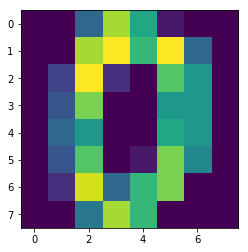

In [6]:
plt.imshow(X[0].reshape((8,8)))

### create model

In [8]:
# lm2 = models['model_classify'].get_layer('gkernel2').get_weights()[0]
# print(lm2.shape)

# gk1_pred = models['model_gk1'].predict(X_sc, batch_size=1024)
# df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,2:5])
# df.shape
# df['cls'] = ['c'+str(ee) for ee in y] + ['Landmark']*lm2.shape[0]
# df.shape
# pp = sns.pairplot(df, markers=['.']*10+['s'], hue='cls', size=2.2)
# axes = pp.axes
# axes
# for ii in range(3):
#     for jj in range(3):
#         axes[ii,jj].set_xlim([0,1])
#         axes[ii,jj].set_ylim([0,1])

In [9]:
import keras

class SaveImage(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        lm2 = models['model_classify'].get_layer('gkernel2').get_weights()[0]
        
        pred_imgA_train = models['model_img_img'].predict({'input_img': X_sc}, batch_size=32, verbose=1)
        
        gk1_pred = models['model_gk1'].predict(pred_imgA_train, batch_size=1024)
        df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,2:5])
        df['cls'] = ['c'+str(ee) for ee in y] + ['Landmark']*lm2.shape[0]
        pp = sns.pairplot(df, markers=['.']*10+['s'], hue='cls', size=2.2)
        axes = pp.axes
        for ii in range(3):
            for jj in range(3):
                axes[ii,jj].set_xlim([-0.1,1.1])
                axes[ii,jj].set_ylim([-0.1,1.1])
        plt.savefig('img/img_{:0=3d}.png'.format(epoch))
        plt.close()
        
#         x_min, x_max = (-3, 3)
#         y_min, y_max = (-3, 3)
#         h = .01
#         xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                              np.arange(y_min, y_max, h))
#         y_pred = self.model.predict(np.c_[xx.ravel(), yy.ravel()], batch_size=1024)
#         #print(y_pred[0])
#         cm = plt.cm.coolwarm
#         cm_bright = ListedColormap(['#FF0000', '#0000FF'])
#         y_pred = y_pred.reshape(xx.shape)
#         plt.figure(figsize=(8, 6))
#         plt.contourf(xx, yy, y_pred, 100, cmap=cm, alpha=1)
#         plt.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright, edgecolors='k')
#         wgt = model.get_layer('gkernel1').get_weights()[0]
#         plt.scatter(wgt[:,0], wgt[:,1], marker='s', s=50, color='yellow', edgecolors='w')
#         plt.savefig('img/img_{:0=3d}.png'.format(epoch))
#         plt.close()


In [10]:
# '''
# chose landmarks from sample
# pick 10 data each digit
# '''
# np.random.seed(0)
# num_lm0 = 10
# num_lm = num_lm0 * 10
# init_list = []
# for ii in range(10):
#     init_wgt0 = X_sc[y==ii]
#     init_wgt0 = init_wgt0[np.random.choice(range(init_wgt0.shape[0]), size=num_lm0, replace=False)] + \
#                 np.random.normal(scale=0.01, size=num_lm0*64).reshape(num_lm0, 64)
#     init_list.append(init_wgt0)
# init_wgt = np.vstack(init_list)
# init_wgt = init_wgt[np.random.permutation(range(init_wgt.shape[0]))]
# init_wgt.shape

In [11]:
np.random.seed(0)
num_lm0 = 20
num_lm = num_lm0 * 10

init_wgt = np.random.random((num_lm, 64))
init_wgt.shape

(200, 64)

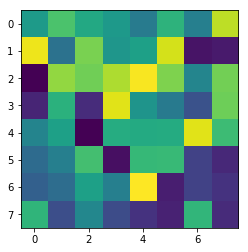

In [12]:
plt.imshow(init_wgt[0].reshape((8,8)))

In [13]:
'''
chose landmarks randomly for gk2
'''
#num_lm2 = 200
num_lm2 = 10
init_lm2 = np.random.random_sample((num_lm2, num_lm))
print(init_lm2.shape)
init_lm2

(10, 200)


array([[ 0.58431159,  0.34604956,  0.80096485, ...,  0.8208002 ,
         0.54146465,  0.83592307],
       [ 0.1460074 ,  0.14468641,  0.21509755, ...,  0.2930167 ,
         0.1365425 ,  0.16336344],
       [ 0.77769598,  0.10129986,  0.1457809 , ...,  0.61764351,
         0.11232001,  0.08894386],
       ..., 
       [ 0.9440396 ,  0.23260062,  0.20628593, ...,  0.43414803,
         0.62319064,  0.44873835],
       [ 0.04061529,  0.92398819,  0.03242099, ...,  0.38065146,
         0.35183282,  0.59557011],
       [ 0.52355113,  0.50109751,  0.26768475, ...,  0.23533055,
         0.4680787 ,  0.99205287]])

In [19]:
def make_modelz(wgt_embed=None):
    '''==============================
    inputs
    =============================='''
    inp_cls = Input(shape=(10,), name='input_cls')
    inp_img = Input(shape=(64,), name='input_img')
    inp_200 = Input(shape=(num_lm,), name='input_200')
    
    '''==============================
    layers
    =============================='''
    if wgt_embed is None:
        layer_dense_embed = Dense(64, use_bias=False, name='embed')
    else:
        layer_dense_embed = Dense(64, use_bias=False, name='embed', weights=[wgt_embed])
    layer_dense_ae = Dense(64, name='dense_ae')
    
    '''Gaussian Kernel 1'''
    weights1 = [init_wgt, np.log(np.array([1./(2.*64*0.1)]))]
    layer_gk1 = GaussianKernel3(num_lm, 64, name='gkernel1', weights=weights1)
    
    '''Gaussian Kernel 2'''
    weights2 = [init_lm2, np.log(np.array([1./(2.*num_lm*0.1)]))]
    layer_gk2 = GaussianKernel3(10, num_lm, weights=weights2, name='gkernel2')
    
    '''==============================
    models
    =============================='''
    oup_gk1 = layer_gk1(inp_img)
    model_gk1 = Model(inp_img, oup_gk1, name='model_gk1')
    
    oup_gk2 = layer_gk2(inp_200)
    model_classify = Model(inp_200, oup_gk2, name='model_classify')
    
    model_embed = Model(inp_cls, layer_dense_embed(inp_cls), name='model_embed')
    
    # ae
    oup_ae = layer_dense_ae(inp_200)
    model_ae = Model(inp_200, oup_ae, name='model_ae')
    
    # img > img
    oup_img_img = model_ae(oup_gk1)
    oup_img_img = Activation('sigmoid', name='output_img')(oup_img_img)
    model_img_img = Model(inp_img, oup_img_img, name='model_img_img')
    
    # img > cls
    oup_img_cls = model_classify(oup_gk1)
    model_img_cls = Model(inp_img, oup_img_cls, name='model_img_cls')
    
    # cls > img
    model_cls_img = Model(inp_cls, model_img_img(model_embed(inp_cls)), name='model_cls_img')
    
    # cls > cls
    model_cls_cls = Model(inp_cls, model_img_cls(model_embed(inp_cls)), name='model_cls_cls')
    
    '''==============================
    cost functions
    =============================='''
    def cost_cls(y_true, y_pred):
        return losses.binary_crossentropy(y_true, y_pred)
    def cost_ae(y_true, y_pred):
        return losses.mse(y_true, y_pred)
    def cost_zero(y_true, y_pred):
        return losses.mse(0, y_pred)
    
    '''=== img -> imgA ==='''
    pass_img_imgA = model_img_img(inp_img)
    pass_img_imgA = Activation('linear', name='pass_img_imgA')(pass_img_imgA)
    
    '''=== cls -> img ==='''
    pass_cls_img = model_cls_img(inp_cls)
    pass_cls_img = Activation('linear', name='pass_cls_img')(pass_cls_img)
    
    '''=== cls -> img -> cls ==='''
    pass_cls_img_cls = model_img_cls(pass_cls_img)
    model_cls_img_cls = Model(inp_cls, pass_cls_img_cls, name='model_cls_img_cls')
    pass_cls_img_cls = Activation('linear', name='pass_cls_img_cls')(pass_cls_img_cls)
    
    '''=== cls > img > cls | cls > img ==='''
    pass_cls_img_cls_img = model_cls_img(model_cls_img_cls(inp_cls))
    pass_cls_img_cls_img = Activation('linear', name='pass_cls_img_cls_img')(pass_cls_img_cls_img)
    
    '''=== cls > img > cls | x2 ==='''
    pass_cls_img_cls_x2 = model_cls_img_cls(model_cls_img_cls(inp_cls))
    pass_cls_img_cls_x2 = Activation('linear', name='pass_cls_img_cls_x2')(pass_cls_img_cls_x2)
    
    pass_fit_imgA = Lambda(lambda x: x[0] - x[1], name='pass_fit_imgA')([
        pass_img_imgA,
        pass_cls_img
    ])
    
    model = Model([inp_img, inp_cls],
                  [pass_cls_img, pass_fit_imgA, pass_cls_img_cls, pass_cls_img_cls_img, pass_cls_img_cls_x2])
    model.compile(loss={
                     'pass_cls_img': cost_ae,
                     'pass_fit_imgA': cost_zero,
                     'pass_cls_img_cls': cost_cls,
                     'pass_cls_img_cls_img': cost_ae,
                     'pass_cls_img_cls_x2': cost_cls,
                  },
                  loss_weights={
                     'pass_cls_img': 1.0,
                     'pass_fit_imgA': 1.0,
                     'pass_cls_img_cls': 1.0,
                     'pass_cls_img_cls_img': 1.0,
                     'pass_cls_img_cls_x2': 1.0,
                  },
                  metrics=['accuracy'],
                  optimizer='adam')
    
    return {
        'model': model,
        'model_embed': model_embed,
        'model_ae': model_ae,
        'model_gk1': model_gk1,
        'model_classify': model_classify,
        
        'model_img_img': model_img_img,
        'model_img_cls': model_img_cls,
        'model_cls_img': model_cls_img,
        'model_cls_cls': model_cls_cls,
        
        'model_cls_img_cls': model_cls_img_cls,
    }

models = make_modelz()
model = models['model']
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_cls (InputLayer)           (None, 10)            0                                            
____________________________________________________________________________________________________
model_cls_img (Model)            (None, 64)            26305       input_cls[0][0]                  
                                                                   model_cls_img_cls[1][0]          
____________________________________________________________________________________________________
input_img (InputLayer)           (None, 64)            0                                            
____________________________________________________________________________________________________
pass_cls_img (Activation)        (None, 64)            0           model_cls_img[1][0]     

In [20]:
wgt = models['model_gk1'].get_layer('gkernel1').get_weights()[0]

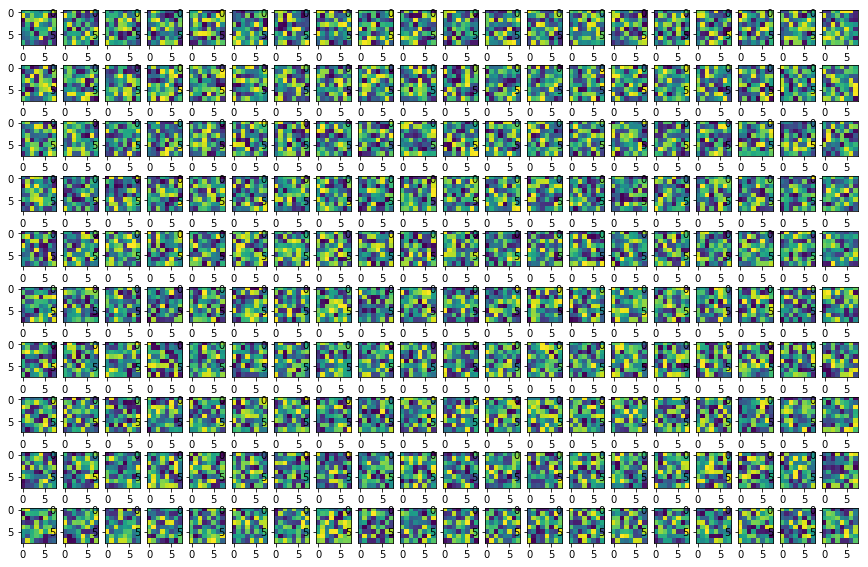

In [16]:
nrows = 10
ncols = 20
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

for ii in range(nrows):
    for jj in range(ncols):
        iplt = subs[ii,jj]
        img_array = wgt[ii*ncols+jj].reshape((8, 8))
        iplt.imshow(img_array)

### train

In [21]:
save_img = SaveImage()

model.fit({'input_img': X_sc, 'input_cls': y_cat},
          {
              'pass_cls_img': X_sc,
              'pass_fit_imgA': X_sc,
              'pass_cls_img_cls': y_cat,
              'pass_cls_img_cls_img': X_sc,
              'pass_cls_img_cls_x2': y_cat,
          },
          verbose=1,
          batch_size=32,
          epochs=150,
          callbacks=[save_img])

/home/admin/miniconda3/envs/snowflakes/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/150
1797/1797 [==============================] - 9s - loss: 1.2967 - pass_cls_img_loss: 0.1336 - pass_fit_imgA_loss: 0.0019 - pass_cls_img_cls_loss: 0.5143 - pass_cls_img_cls_img_loss: 0.1380 - pass_cls_img_cls_x2_loss: 0.5089 - pass_cls_img_acc: 0.0401 - pass_fit_imgA_acc: 0.0134 - pass_cls_img_cls_acc: 0.0991 - pass_cls_img_cls_img_acc: 0.0467 - pass_cls_img_cls_x2_acc: 0.0991     
Epoch 2/150
1797/1797 [==============================] - 8s - loss: 0.8792 - pass_cls_img_loss: 0.0970 - pass_fit_imgA_loss: 0.0019 - pass_cls_img_cls_loss: 0.3415 - pass_cls_img_cls_img_loss: 0.0938 - pass_cls_img_cls_x2_loss: 0.3450 - pass_cls_img_acc: 0.0684 - pass_fit_imgA_acc: 0.0428 - pass_cls_img_cls_acc: 0.0991 - pass_cls_img_cls_img_acc: 0.0640 - pass_cls_img_cls_x2_acc: 0.0991     
Epoch 3/150
1797/1797 [==============================] - 8s - loss: 0.8189 - pass_cls_img_loss: 0.0804 - pass_fit_imgA_loss: 0.0010 - pass_cls_img_cls_loss: 0.3283 - pass_cls_img_cls_img_loss: 0.0791 - pass_cls

1797/1797 [==============================] - 8s - loss: 0.6751 - pass_cls_img_loss: 0.0593 - pass_fit_imgA_loss: 0.0078 - pass_cls_img_cls_loss: 0.2661 - pass_cls_img_cls_img_loss: 0.0657 - pass_cls_img_cls_x2_loss: 0.2763 - pass_cls_img_acc: 0.0428 - pass_fit_imgA_acc: 0.0033 - pass_cls_img_cls_acc: 0.5915 - pass_cls_img_cls_img_acc: 0.0451 - pass_cls_img_cls_x2_acc: 0.3573     
Epoch 19/150
1797/1797 [==============================] - 8s - loss: 0.6365 - pass_cls_img_loss: 0.0601 - pass_fit_imgA_loss: 0.0100 - pass_cls_img_cls_loss: 0.2461 - pass_cls_img_cls_img_loss: 0.0637 - pass_cls_img_cls_x2_loss: 0.2566 - pass_cls_img_acc: 0.0445 - pass_fit_imgA_acc: 0.0028 - pass_cls_img_cls_acc: 0.7362 - pass_cls_img_cls_img_acc: 0.0306 - pass_cls_img_cls_x2_acc: 0.4997     
Epoch 20/150
1797/1797 [==============================] - 8s - loss: 0.5929 - pass_cls_img_loss: 0.0610 - pass_fit_imgA_loss: 0.0111 - pass_cls_img_cls_loss: 0.2259 - pass_cls_img_cls_img_loss: 0.0627 - pass_cls_img_cls_x

1797/1797 [==============================] - 8s - loss: 0.1675 - pass_cls_img_loss: 0.0478 - pass_fit_imgA_loss: 0.0096 - pass_cls_img_cls_loss: 0.0315 - pass_cls_img_cls_img_loss: 0.0484 - pass_cls_img_cls_x2_loss: 0.0303 - pass_cls_img_acc: 0.0534 - pass_fit_imgA_acc: 0.0072 - pass_cls_img_cls_acc: 1.0000 - pass_cls_img_cls_img_acc: 0.0512 - pass_cls_img_cls_x2_acc: 1.0000     
Epoch 36/150
1797/1797 [==============================] - 10s - loss: 0.1530 - pass_cls_img_loss: 0.0472 - pass_fit_imgA_loss: 0.0094 - pass_cls_img_cls_loss: 0.0250 - pass_cls_img_cls_img_loss: 0.0476 - pass_cls_img_cls_x2_loss: 0.0239 - pass_cls_img_acc: 0.0529 - pass_fit_imgA_acc: 0.0072 - pass_cls_img_cls_acc: 1.0000 - pass_cls_img_cls_img_acc: 0.0545 - pass_cls_img_cls_x2_acc: 1.0000    
Epoch 37/150
1797/1797 [==============================] - 8s - loss: 0.1409 - pass_cls_img_loss: 0.0466 - pass_fit_imgA_loss: 0.0092 - pass_cls_img_cls_loss: 0.0196 - pass_cls_img_cls_img_loss: 0.0468 - pass_cls_img_cls_x

1797/1797 [==============================] - 8s - loss: 0.0962 - pass_cls_img_loss: 0.0434 - pass_fit_imgA_loss: 0.0066 - pass_cls_img_cls_loss: 0.0015 - pass_cls_img_cls_img_loss: 0.0433 - pass_cls_img_cls_x2_loss: 0.0015 - pass_cls_img_acc: 0.0690 - pass_fit_imgA_acc: 0.0095 - pass_cls_img_cls_acc: 1.0000 - pass_cls_img_cls_img_acc: 0.0690 - pass_cls_img_cls_x2_acc: 1.0000     
Epoch 53/150
1797/1797 [==============================] - 8s - loss: 0.0958 - pass_cls_img_loss: 0.0433 - pass_fit_imgA_loss: 0.0064 - pass_cls_img_cls_loss: 0.0014 - pass_cls_img_cls_img_loss: 0.0433 - pass_cls_img_cls_x2_loss: 0.0014 - pass_cls_img_acc: 0.0807 - pass_fit_imgA_acc: 0.0078 - pass_cls_img_cls_acc: 1.0000 - pass_cls_img_cls_img_acc: 0.0824 - pass_cls_img_cls_x2_acc: 1.0000     
Epoch 54/150
1797/1797 [==============================] - 8s - loss: 0.0953 - pass_cls_img_loss: 0.0433 - pass_fit_imgA_loss: 0.0063 - pass_cls_img_cls_loss: 0.0013 - pass_cls_img_cls_img_loss: 0.0432 - pass_cls_img_cls_x

1797/1797 [==============================] - 8s - loss: 0.0920 - pass_cls_img_loss: 0.0429 - pass_fit_imgA_loss: 0.0053 - pass_cls_img_cls_loss: 5.2782e-04 - pass_cls_img_cls_img_loss: 0.0429 - pass_cls_img_cls_x2_loss: 5.1649e-04 - pass_cls_img_acc: 0.0646 - pass_fit_imgA_acc: 0.0100 - pass_cls_img_cls_acc: 1.0000 - pass_cls_img_cls_img_acc: 0.0668 - pass_cls_img_cls_x2_acc: 1.0000     
Epoch 70/150
1797/1797 [==============================] - 8s - loss: 0.0919 - pass_cls_img_loss: 0.0429 - pass_fit_imgA_loss: 0.0052 - pass_cls_img_cls_loss: 5.2285e-04 - pass_cls_img_cls_img_loss: 0.0429 - pass_cls_img_cls_x2_loss: 5.1437e-04 - pass_cls_img_acc: 0.0651 - pass_fit_imgA_acc: 0.0095 - pass_cls_img_cls_acc: 1.0000 - pass_cls_img_cls_img_acc: 0.0651 - pass_cls_img_cls_x2_acc: 1.0000     
Epoch 71/150
1797/1797 [==============================] - 8s - loss: 0.0919 - pass_cls_img_loss: 0.0429 - pass_fit_imgA_loss: 0.0051 - pass_cls_img_cls_loss: 5.1706e-04 - pass_cls_img_cls_img_loss: 0.0429 

1797/1797 [==============================] - 8s - loss: 0.0910 - pass_cls_img_loss: 0.0428 - pass_fit_imgA_loss: 0.0045 - pass_cls_img_cls_loss: 3.7790e-04 - pass_cls_img_cls_img_loss: 0.0428 - pass_cls_img_cls_x2_loss: 3.7393e-04 - pass_cls_img_acc: 0.0534 - pass_fit_imgA_acc: 0.0111 - pass_cls_img_cls_acc: 1.0000 - pass_cls_img_cls_img_acc: 0.0534 - pass_cls_img_cls_x2_acc: 1.0000     
Epoch 86/150
1797/1797 [==============================] - 8s - loss: 0.0907 - pass_cls_img_loss: 0.0428 - pass_fit_imgA_loss: 0.0045 - pass_cls_img_cls_loss: 3.0964e-04 - pass_cls_img_cls_img_loss: 0.0428 - pass_cls_img_cls_x2_loss: 3.0712e-04 - pass_cls_img_acc: 0.0612 - pass_fit_imgA_acc: 0.0117 - pass_cls_img_cls_acc: 1.0000 - pass_cls_img_cls_img_acc: 0.0612 - pass_cls_img_cls_x2_acc: 1.0000     
Epoch 87/150
1797/1797 [==============================] - 8s - loss: 0.0907 - pass_cls_img_loss: 0.0428 - pass_fit_imgA_loss: 0.0045 - pass_cls_img_cls_loss: 3.2253e-04 - pass_cls_img_cls_img_loss: 0.0428 

1797/1797 [==============================] - 8s - loss: 0.0902 - pass_cls_img_loss: 0.0428 - pass_fit_imgA_loss: 0.0041 - pass_cls_img_cls_loss: 2.8567e-04 - pass_cls_img_cls_img_loss: 0.0428 - pass_cls_img_cls_x2_loss: 2.8191e-04 - pass_cls_img_acc: 0.0957 - pass_fit_imgA_acc: 0.0122 - pass_cls_img_cls_acc: 1.0000 - pass_cls_img_cls_img_acc: 0.0974 - pass_cls_img_cls_x2_acc: 1.0000     
Epoch 103/150
1797/1797 [==============================] - 8s - loss: 0.0902 - pass_cls_img_loss: 0.0428 - pass_fit_imgA_loss: 0.0040 - pass_cls_img_cls_loss: 2.6687e-04 - pass_cls_img_cls_img_loss: 0.0428 - pass_cls_img_cls_x2_loss: 2.6434e-04 - pass_cls_img_acc: 0.0512 - pass_fit_imgA_acc: 0.0139 - pass_cls_img_cls_acc: 1.0000 - pass_cls_img_cls_img_acc: 0.0518 - pass_cls_img_cls_x2_acc: 1.0000     
Epoch 104/150
1797/1797 [==============================] - 8s - loss: 0.0900 - pass_cls_img_loss: 0.0428 - pass_fit_imgA_loss: 0.0039 - pass_cls_img_cls_loss: 2.3199e-04 - pass_cls_img_cls_img_loss: 0.042

1797/1797 [==============================] - 8s - loss: 0.0896 - pass_cls_img_loss: 0.0428 - pass_fit_imgA_loss: 0.0036 - pass_cls_img_cls_loss: 2.3119e-04 - pass_cls_img_cls_img_loss: 0.0428 - pass_cls_img_cls_x2_loss: 2.3048e-04 - pass_cls_img_acc: 0.0529 - pass_fit_imgA_acc: 0.0145 - pass_cls_img_cls_acc: 1.0000 - pass_cls_img_cls_img_acc: 0.0529 - pass_cls_img_cls_x2_acc: 1.0000     
Epoch 120/150
1797/1797 [==============================] - 8s - loss: 0.0896 - pass_cls_img_loss: 0.0428 - pass_fit_imgA_loss: 0.0035 - pass_cls_img_cls_loss: 2.4038e-04 - pass_cls_img_cls_img_loss: 0.0428 - pass_cls_img_cls_x2_loss: 2.3514e-04 - pass_cls_img_acc: 0.0707 - pass_fit_imgA_acc: 0.0167 - pass_cls_img_cls_acc: 1.0000 - pass_cls_img_cls_img_acc: 0.0718 - pass_cls_img_cls_x2_acc: 1.0000     
Epoch 121/150
1797/1797 [==============================] - 8s - loss: 0.0895 - pass_cls_img_loss: 0.0428 - pass_fit_imgA_loss: 0.0035 - pass_cls_img_cls_loss: 2.0314e-04 - pass_cls_img_cls_img_loss: 0.042

1797/1797 [==============================] - 8s - loss: 0.0890 - pass_cls_img_loss: 0.0428 - pass_fit_imgA_loss: 0.0030 - pass_cls_img_cls_loss: 2.3142e-04 - pass_cls_img_cls_img_loss: 0.0428 - pass_cls_img_cls_x2_loss: 2.2680e-04 - pass_cls_img_acc: 0.0751 - pass_fit_imgA_acc: 0.0178 - pass_cls_img_cls_acc: 1.0000 - pass_cls_img_cls_img_acc: 0.0757 - pass_cls_img_cls_x2_acc: 1.0000     
Epoch 137/150
1797/1797 [==============================] - 16s - loss: 0.0889 - pass_cls_img_loss: 0.0428 - pass_fit_imgA_loss: 0.0030 - pass_cls_img_cls_loss: 1.7092e-04 - pass_cls_img_cls_img_loss: 0.0428 - pass_cls_img_cls_x2_loss: 1.7101e-04 - pass_cls_img_acc: 0.0556 - pass_fit_imgA_acc: 0.0178 - pass_cls_img_cls_acc: 1.0000 - pass_cls_img_cls_img_acc: 0.0562 - pass_cls_img_cls_x2_acc: 1.0000    
Epoch 138/150
1797/1797 [==============================] - 8s - loss: 0.0889 - pass_cls_img_loss: 0.0428 - pass_fit_imgA_loss: 0.0030 - pass_cls_img_cls_loss: 1.8761e-04 - pass_cls_img_cls_img_loss: 0.042

In [22]:
pred_imgA = models['model_img_img'].predict({'input_img': X_sc}, batch_size=32, verbose=1)
print(pred_imgA.shape)

1760/1797 [============================>.] - ETA: 0s(1797, 64)


In [23]:
y_pred = models['model_img_cls'].predict({'input_img': pred_imgA})
print(y_pred.shape)
y_pred

(1797, 10)


array([[  8.79009128e-01,   2.84079624e-06,   6.38594247e-06, ...,
          9.94970924e-06,   1.50160915e-07,   1.77886541e-05],
       [  2.52584209e-06,   6.48492098e-01,   4.49381114e-05, ...,
          2.41089147e-05,   1.88344529e-05,   3.32485888e-06],
       [  1.01762516e-05,   1.89367291e-02,   9.34778005e-02, ...,
          1.10596826e-04,   2.57985909e-02,   2.05908815e-04],
       ..., 
       [  3.00767829e-06,   8.88768863e-03,   9.61989499e-05, ...,
          7.97520333e-05,   5.45140386e-01,   1.37146781e-04],
       [  6.40674698e-05,   4.17273623e-05,   1.48492763e-05, ...,
          2.87230287e-05,   5.01268543e-04,   8.56021464e-01],
       [  3.46596880e-06,   1.97987724e-03,   1.83828175e-04, ...,
          5.04943491e-05,   6.87512994e-01,   4.26826329e-04]], dtype=float32)

In [24]:
confusion_matrix(y, np.argmax(y_pred, axis=1))

array([[178,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 172,   0,   0,   0,   0,   0,   0,  10,   0],
       [  0,   0, 173,   0,   0,   0,   0,   0,   4,   0],
       [  0,   0,   0, 172,   0,   1,   0,   0,  10,   0],
       [  0,   0,   0,   0, 177,   0,   0,   1,   3,   0],
       [  0,   0,   0,   0,   0, 177,   0,   0,   2,   3],
       [  0,   2,   0,   0,   0,   0, 177,   0,   2,   0],
       [  0,   0,   0,   0,   0,   0,   0, 176,   2,   1],
       [  0,   4,   0,   0,   0,   0,   0,   0, 170,   0],
       [  0,   0,   0,   1,   0,   1,   0,   0,   9, 169]])

In [25]:
print(classification_report(y, np.argmax(y_pred, axis=1)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       178
          1       0.97      0.95      0.96       182
          2       1.00      0.98      0.99       177
          3       0.99      0.94      0.97       183
          4       1.00      0.98      0.99       181
          5       0.99      0.97      0.98       182
          6       1.00      0.98      0.99       181
          7       0.99      0.98      0.99       179
          8       0.80      0.98      0.88       174
          9       0.98      0.94      0.96       180

avg / total       0.97      0.97      0.97      1797



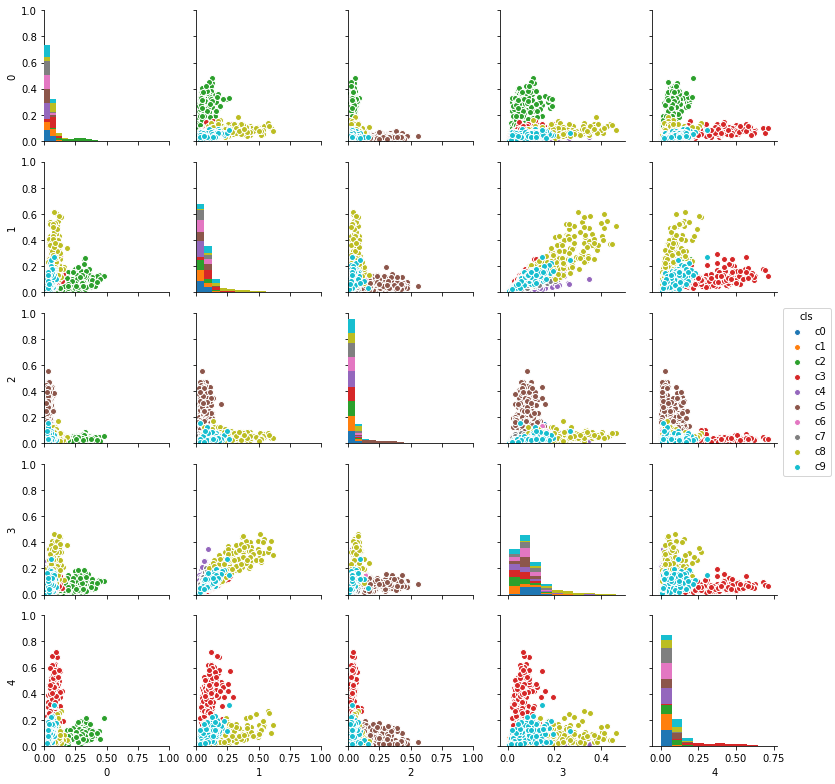

In [26]:
gk1_pred = models['model_gk1'].predict(X_sc, batch_size=1024)
df = pd.DataFrame(gk1_pred[:,:5])
df['cls'] = ['c'+str(ee) for ee in y]
pp = sns.pairplot(df, markers='o', hue='cls', size=2.2)
axes = pp.axes
for ii in range(5):
    for jj in range(3):
        axes[ii,jj].set_xlim([0,1])
        axes[ii,jj].set_ylim([0,1])

1797/1797 [==============================] - 0s     
(1797, 64)


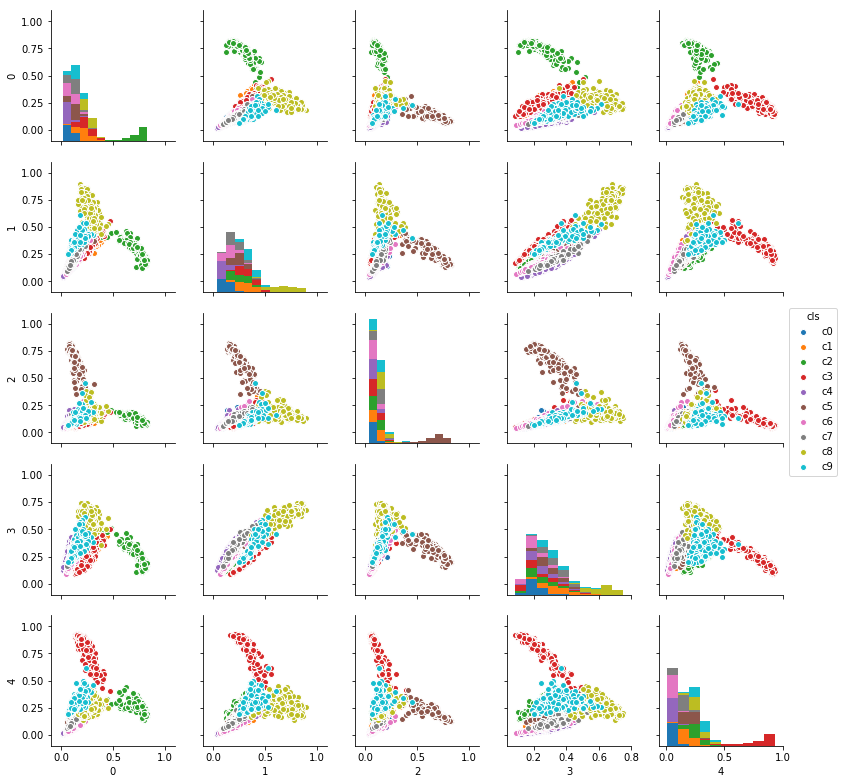

In [33]:
pred_imgA_train = models['model_img_img'].predict({'input_img': X_sc}, batch_size=32, verbose=1)
print(pred_imgA_train.shape)

gk1_pred = models['model_gk1'].predict(pred_imgA_train, batch_size=1024)
df = pd.DataFrame(gk1_pred[:,:5])
df['cls'] = ['c'+str(ee) for ee in y]
pp = sns.pairplot(df, markers='o', hue='cls', size=2.2)
axes = pp.axes
for ii in range(5):
    for jj in range(3):
        axes[ii,jj].set_xlim([-0.1,1.1])
        axes[ii,jj].set_ylim([-0.1,1.1])

(10, 200)
1536/1797 [========================>.....] - ETA: 0s(1797, 64)


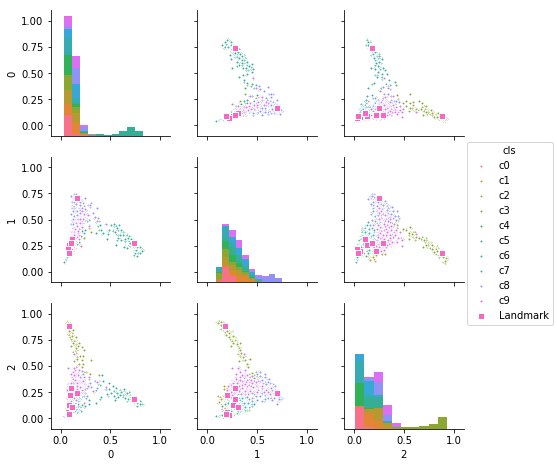

In [34]:
lm2 = models['model_classify'].get_layer('gkernel2').get_weights()[0]
print(lm2.shape)

pred_imgA_train = models['model_img_img'].predict({'input_img': X_sc}, batch_size=32, verbose=1)
print(pred_imgA_train.shape)

gk1_pred = models['model_gk1'].predict(pred_imgA_train, batch_size=1024)
df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,2:5])
df.shape
df['cls'] = ['c'+str(ee) for ee in y] + ['Landmark']*lm2.shape[0]
df.shape
pp = sns.pairplot(df, markers=['.']*10+['s'], hue='cls', size=2.2)
axes = pp.axes
axes
for ii in range(3):
    for jj in range(3):
        axes[ii,jj].set_xlim([-0.1,1.1])
        axes[ii,jj].set_ylim([-0.1,1.1])


(10, 200)
1664/1797 [==========================>...] - ETA: 0s(1797, 64)


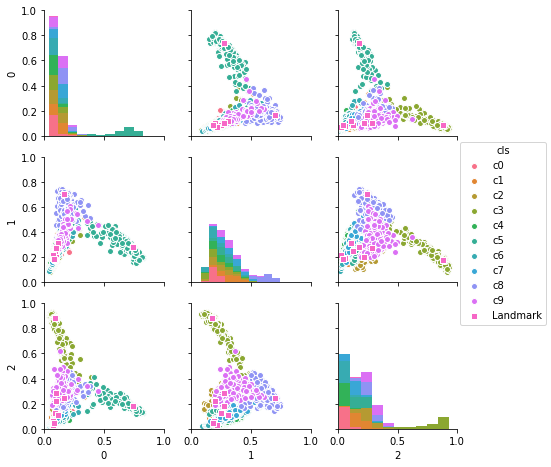

In [32]:
lm2 = models['model_classify'].get_layer('gkernel2').get_weights()[0]
print(lm2.shape)

pred_imgA_train = models['model_img_img'].predict({'input_img': X_sc}, batch_size=32, verbose=1)
print(pred_imgA_train.shape)

gk1_pred = models['model_gk1'].predict(pred_imgA_train, batch_size=1024)
df = pd.DataFrame(np.vstack([gk1_pred, lm2])[:,2:5])
df.shape
df['cls'] = ['c'+str(ee) for ee in y] + ['Landmark']*lm2.shape[0]
df.shape
pp = sns.pairplot(df, markers=['o']*10+['s'], hue='cls', size=2.2)
axes = pp.axes
axes
for ii in range(3):
    for jj in range(3):
        axes[ii,jj].set_xlim([0,1])
        axes[ii,jj].set_ylim([0,1])


In [29]:
wgt = models['model_gk1'].get_layer('gkernel1').get_weights()[0]

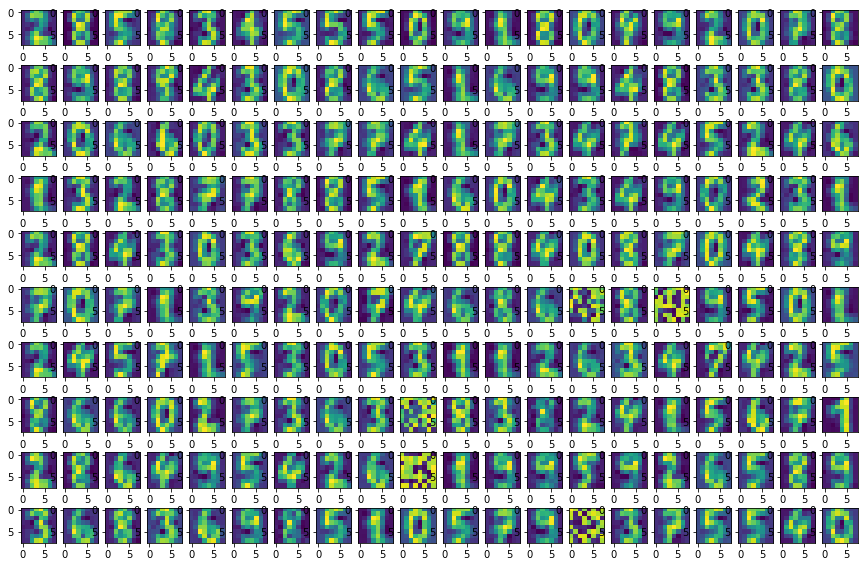

In [30]:
nrows = 10
ncols = 20
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

for ii in range(nrows):
    for jj in range(ncols):
        iplt = subs[ii,jj]
        img_array = wgt[ii*ncols+jj].reshape((8, 8))
        iplt.imshow(img_array)